<a href="https://colab.research.google.com/github/NongNNew/Project_499/blob/main/Project_499_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN**

## Setup

In [43]:
!pip install python_speech_features

In [44]:
import librosa
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
from tensorflow import keras 
import python_speech_features
import matplotlib.pyplot as plt
from scipy.signal.windows import hamming
from sklearn.metrics import classification_report

In [45]:
np.random.seed(1)
tf.random.set_seed(1)

In [46]:
# Upload audio files from github
!git clone https://github.com/NongNNew/Project_499.git

fatal: destination path 'Project_499' already exists and is not an empty directory.


## Prepare dataset

In [47]:
# Name of vegetables and fruits 52 types of 56 classes
fruit_veget = ['กระชาย','กระท้อน','กระเทียม1','กระเทียม2','กระเพรา','กล้วยน้ำว้า','กล้วยหอม',
               'ข้าวโพด','ไข่น้ำ',
               'ตะขบไทย','ตะไคร้',
               'ถั่วฝักยาว','ถั่วลันเตา','ถั่วลิสง',
               'ทับทิม',
               'น้อยหน่า','น้ำเต้า',
               'ผักกระเฉด','ผักกุยช่าย','ผักขึ้นช่าย','ผักชะอม','ผักชี','ผักชีฝรั่ง','ผักตำลึง',
               'มะปราง','มะพลับ','มะละกอ','มะกรูด','มะเขือพวง','มะเขือเทศ','มะระ','มะรุม','มะตูม','มันแกว1','มันแกว2','มันเทศ','มันฝรั่ง','มันสำปะหลัง',
               'บวบ','ใบชะพลู1','ใบชะพลู2','ใบบัวบก','ใบแมงลัก','ใบยอ',
               'พริกขี้หนู','พริกสด','พุทรา','เพกา',
               'ฝรั่ง',
               'ฟัก','ฟักทอง',
               'สับปะรด','สะเดา','สะระแหน่',
               'หัวหอม1','หัวหอม2']

# Audio data source
source = {'audio_time':[],
          'sampling_rate':[],
          'feature_extraction':[],
          'label':[],
          'description':[]}

In [48]:
def feature_mfcc(y,sr):
    return (python_speech_features.mfcc(signal=y, 
                                    samplerate=sr, 
                                    winlen= 512/sr, 
                                    winstep= 160/sr,
                                    numcep= 13,
                                    nfilt= 40, 
                                    nfft= 512,
                                    lowfreq= 0,
                                    highfreq= None,
                                    preemph= 0.97, 
                                    ceplifter= 0,
                                    winfunc= hamming))

In [49]:
for types in fruit_veget:
    audio_files = glob('/content/Project_499/Record_audio/' + str(types) + '/*.wav')

    for audio in audio_files:
        y,sr = librosa.load(audio,duration=5,offset=0)
        source['description'].append(str(types))
        source['audio_time'].append(y)
        source['sampling_rate'].append(sr)
        source['feature_extraction'].append(feature_mfcc(y,sr))
        source['label'].append(fruit_veget.index(types))

In [50]:
# tranform dictionary to dataframe 
df = pd.DataFrame.from_dict(source)
df

,audio_time,sampling_rate,feature_extraction,label,description
0,"[-0.00024414062, -0.0002593994, -0.00022888184...",22050,"[[-13.849791727695862, -11.588470019049367, -0...",0,กระชาย
1,"[1.5258789e-05, -3.0517578e-05, 6.1035156e-05,...",22050,"[[-14.225420647550473, -11.767209141048717, 0....",0,กระชาย
2,"[1.5258789e-05, -4.5776367e-05, 0.0, 1.5258789...",22050,"[[-13.973324319319042, -9.651651413346334, 0.8...",0,กระชาย
3,"[-0.00021362305, -0.00024414062, -0.0002593994...",22050,"[[-14.389836672385517, -10.023800010987056, 0....",0,กระชาย
4,"[-0.004928589, -0.0049591064, -0.0048980713, -...",22050,"[[-12.959169471954294, -4.281586674957866, 6.4...",0,กระชาย
...,...,...,...,...,...
1115,"[-0.00024414062, -0.0002593994, -0.00022888184...",22050,"[[-14.003234060711906, -11.759421272003904, -1...",55,หัวหอม2
1116,"[-0.00010681152, -0.00010681152, -0.0002136230...",22050,"[[-13.965644315403711, -9.922440291030709, 1.8...",55,หัวหอม2
1117,"[-0.00024414062, -0.0002746582, -0.00019836426...",22050,"[[-14.30657814127106, -8.777075651980645, 2.11...",55,หัวหอม2
1118,"[-0.00021362305, -0.00019836426, -0.0001678466...",22050,"[[-13.600642153773194, -15.096089567076714, -0...",55,หัวหอม2


In [51]:
Test = pd.DataFrame(columns=source.keys())

# Create test data

for description in np.unique(df['description']):
    imp_test = df[df['description']==description].sample(5,random_state=1)
    Test = pd.concat([Test,imp_test], axis=0)
Train = df.drop(Test.index)

X_train = np.array(Train['feature_extraction'].to_list())
X_test = np.array(Test['feature_extraction'].to_list())
y_train = np.array(Train['label'].to_list())
y_test = np.array(Test['label'].to_list())

In [52]:
# Proportion of data
y_train.shape, y_test.shape

((840,), (280,))

## Build cnn model

In [53]:
def create_cnn_model(X_train):
    np.random.seed(1)
    tf.random.set_seed(1)
    model = None
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(128, 5, input_shape=(X_train.shape[1], X_train.shape[2], 1), activation='relu'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.Conv2D(64, 5, activation='relu',padding='same'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.Conv2D(64, 5, activation='relu',padding='same'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(len(np.unique(df['label'])), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

## Train model

In [54]:
# Train model
model_cnn = create_cnn_model(X_train)
history = model_cnn.fit(X_train[:,:,:,None], y_train, epochs=100, validation_data=(X_test[:,:,:,None],y_test),batch_size=80)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 683, 9, 128)       3328      
_________________________________________________________________
dropout_10 (Dropout)         (None, 683, 9, 128)       0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 341, 4, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 341, 4, 64)        204864    
_________________________________________________________________
dropout_11 (Dropout)         (None, 341, 4, 64)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 170, 2, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 170, 2, 64)       

## Evaluate and predict test set

In [55]:
# Evaluate model
print(f'Test Accuracy: {model_cnn.evaluate(X_test[:,:,:,None],y_test,verbose=0)[1]}')

Test Accuracy: 0.9750000238418579


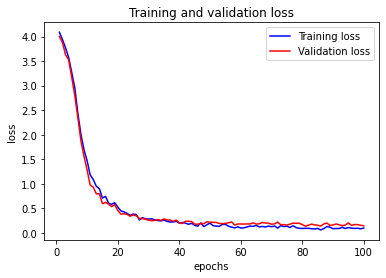

In [56]:
# Learning curve
# plot the accuracy and loss plots between training and validation data
# verify overfitting or underfit 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1,len(acc)+1)

plt.plot(x,loss,'b',label='Training loss')
plt.plot(x,val_loss,'r',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [57]:
# classification report
predicted_classes = np.argmax(np.round(model_cnn.predict(X_test[:,:,:,None])),axis=1)
correct = np.where(predicted_classes==y_test)[0]
target_names = [f"Class {label}" for label in range(len(np.unique(df['label'])))]

print(f"From {len(y_test)} labels're founding {len(correct)} correct labels.")
print(f'Accuracy: {len(correct)/len(y_test)}')
print('')
print(classification_report(y_test, predicted_classes, target_names=target_names))

From 280 labels're founding 268 correct labels.
Accuracy: 0.9571428571428572

              precision    recall  f1-score   support

     Class 0       0.29      1.00      0.45         5
     Class 1       1.00      1.00      1.00         5
     Class 2       1.00      1.00      1.00         5
     Class 3       1.00      0.80      0.89         5
     Class 4       1.00      1.00      1.00         5
     Class 5       1.00      1.00      1.00         5
     Class 6       1.00      1.00      1.00         5
     Class 7       1.00      1.00      1.00         5
     Class 8       1.00      1.00      1.00         5
     Class 9       1.00      0.80      0.89         5
    Class 10       1.00      1.00      1.00         5
    Class 11       1.00      1.00      1.00         5
    Class 12       1.00      1.00      1.00         5
    Class 13       1.00      1.00      1.00         5
    Class 14       1.00      1.00      1.00         5
    Class 15       1.00      1.00      1.00         5
   

## Other people 
men and woman each 10 audio file.

In [58]:
import numpy as np
np.random.seed(77)

random_fruit_veget = np.random.choice(np.unique(df['description']),10,replace=False).tolist()
print(random_fruit_veget)

['ผักกุยช่าย', 'ทับทิม', 'ใบชะพลู1', 'พริกขี้หนู', 'มันสำปะหลัง', 'ฟักทอง', 'มะพลับ', 'หัวหอม2', 'ใบชะพลู2', 'บวบ']


In [59]:
import pandas as pd

# Audio data source
other_source = {'audio_time':[],
                'sampling_rate':[],
                'feature_extraction':[],
                'label':[],
                'description':[]}

for types in random_fruit_veget:
    audio_files = glob('/content/Project_499/Record_other_audio/' + str(types) + '/*.wav')

    for audio in audio_files:
        y,sr = librosa.load(audio,duration=5,offset=0)
        other_source['description'].append(str(types))
        other_source['audio_time'].append(y)
        other_source['sampling_rate'].append(sr)
        other_source['feature_extraction'].append(feature_mfcc(y,sr))

other_source['label'] = [18,18,14,14,39,39,44,44,37,37,50,50,25,25,55,55,40,40,38,38]
other_df = pd.DataFrame.from_dict(other_source)

In [60]:
other_X_test = np.array(other_df['feature_extraction'].to_list())
other_y_test = np.array(other_df['label'].to_list())

In [61]:
# classification report
predicted_classes = np.argmax(np.round(model_cnn.predict(other_X_test[:,:,:,None])),axis=1)
correct = np.where(predicted_classes==other_y_test)[0]
target_names = [f"Class {label}" for label in np.unique(other_source['label'])]

print(f"From {len(other_y_test)} labels're founding {len(correct)} correct labels.")
print(f'Accuracy: {len(correct)/len(other_y_test)}')

From 20 labels're founding 9 correct labels.
Accuracy: 0.45
